In [8]:
!pip install gymnasium
!pip install "gymnasium[classic-control]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Basic concepts and commands

In [10]:
import gymnasium as gym
env = gym.make('CartPole-v1', render_mode='rgb_array')
state, info = env.reset(seed=42)
print(state)

import matplotlib.pyplot as plt

def render():

    state_image = env.render()
    plt.imshow(state_image)
    plt.show()

# Create the Cliff Walking environment
env = gym.make('CliffWalking-v0')

# Compute the size of the action space
num_actions = env.action_space.n

# Compute the size of the state space
num_states = env.observation_space.n

[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


In [1]:
import matplotlib.pyplot as plt
import gymnasium as gym

gamma = 1

# env = gym.make('CartPole-v1', render_mode='rgb_array')
# state, info = env.reset(seed=42)

# Way to get the next state and reward for a give state
# _, next_state, reward, _ = env.unwrapped.P[state][action][0]

terminal_state = False
# Complete the function
def compute_state_value(state, policy):
    if state == terminal_state:
        return 0
    action = policy[state]
    _, next_state, reward, _ = env.unwrapped.P[state][action][0]
    return reward + gamma * compute_state_value(next_state, policy)

# Complete the function to compute the action-value for a state-action pair
def compute_q_value(state, action, policy):
    if state == terminal_state:
        return None   
    _, next_state, reward, _ = env.unwrapped.P[state][action][0]
    return reward + gamma * compute_state_value(next_state, policy)

# Improving policy
# improved_policy = {}

# for state in range(num_states-1):
#     # Find the best action for each state based on Q-values
#     max_action = max(range(num_actions), key=lambda action: Q[(state, action)])
#     improved_policy[state] = max_action

# Rendering a policy
def render():

    state_image = env.render()
    plt.imshow(state_image)
    plt.show()

# terminated = False
# while not terminated:
#   # Select action based on policy 
#   action = improved_policy[state]
#   # Execute the action
#   state, reward, terminated, truncated, info = env.step(action)
#   render()

### Sample Q value grid
```
q_value_grid = {
    (state, action): q_value,
    ...
}
```
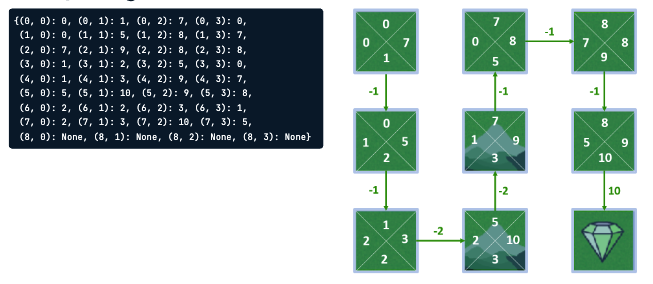

In [17]:
q_grid = {
    (0,0):0,
    (0,1):1,
    (0,2):7,
    (0.3):0
}

## Policy evaluation

### Policy iteration method

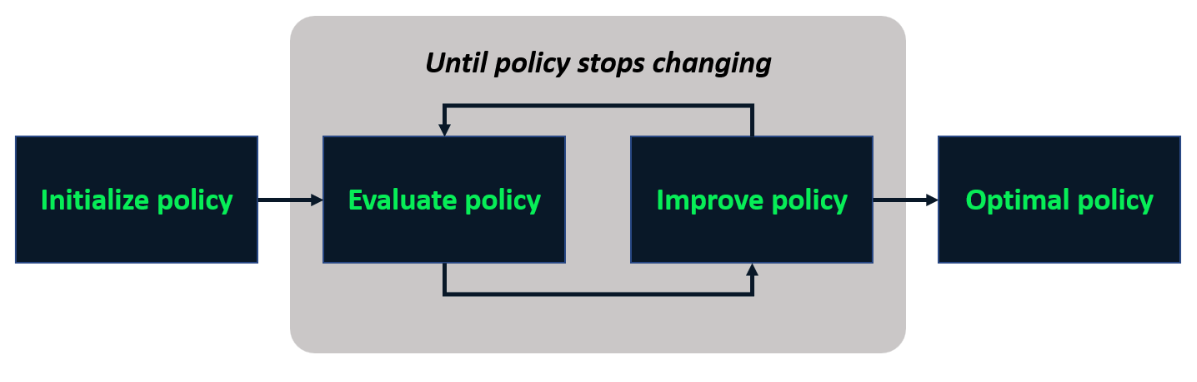

In [2]:
# policy evaluation function
def policy_evaluation(policy):
    '''Creates state value for a given policy'''
    V = {state: compute_state_value(state, policy) for state in range(num_states)}
    return V

# policy improvment
def policy_improvement(policy):

    # Initialize improved policy
    improved_policy = {s:0 for s in range(num_states-1)}

    # Compute Q for each state action pair
    Q = {
        (state, action): compute_q_value(state, action, policy) 
        for state in num_states
        for action in num_actions
    }

    # Find the action with max q for each state and insert that in the initialized improved policy
    for state in range(num_states):

        max_action = max(range(num_actions), key=lambda action: Q[(state, action)])
        improved_policy[state] = max_action

    return improved_policy

# policy iteration
def policy_iteration(policy):

    # Start a loop
    while True:

        # Calculate V and improved policy for a given policy
        V = policy_evaluation(policy)
        improved_policy = policy_improvement(policy)

        # If policy stops imporving, break look
        if improved_policy == policy:
            break
        policy = improved_policy

    # and return policy and V
    return policy, V


### Value iteration
This is based on the concept that V in a subset of Q (or V is Q for one single action)

1. V is assumed as 0 at the beginning
2. Q is calculated
3. V = max(Q) for each state and this is updated
4. Repeat until V stops changing
5. Select the actions for optimal V once V stops changing

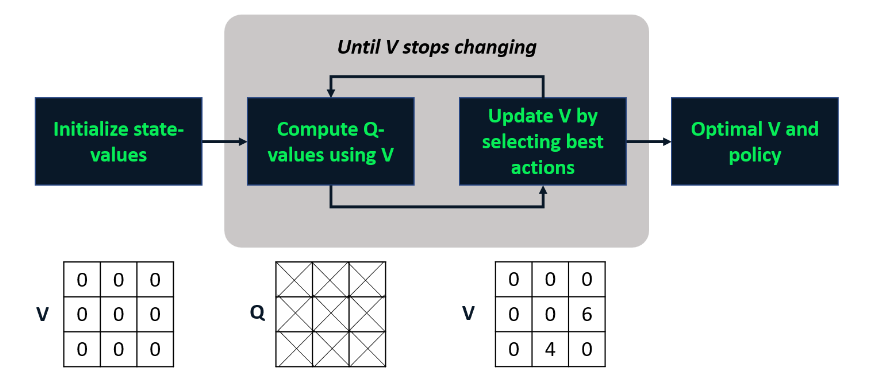

In [8]:
# Q values are computed based on V and not on policy
def compuate_q_value(state, action, V):
    if state == terminal_state:
        return None
    _, next_state, reward, _ = env.P[state][action][0]
    return reward + gamma * V[next_state]

# Function to calculate Q values from V
def get_max_action_and_value(state, V):
    Q_values = [compute_q_value(state, action, V) for action in range(num_actions)]
    max_action = max(range(num_actions), key=lambda a: Q_values[a])
    max_q_value =  Q_values[max_action]
    return max_action, max_q_value

def value_iteration():

    # Initialize V, policy and threshold
    V = {state:0 for state in range(num_states)}
    policy = {s:0 for s in range(num_states-1)}
    threshold = 0.001

    while True:

        # Initialize new V
        new_V = {state:0 for state in range(num_states)}

        for state in range(num_states-1):

            # For each state, from the V get the Q and the action that has the highest Q
            max_action, max_q_value = get_max_action_and_value(state, V)
            new_V[state] = max_q_value
            policy[state] = max_action

        # If the V stops improving, break the loop
        if (all(abs(new_V[state] - V[state])) < threshold for state in V):
            break
        
        V = new_V

    return policy, V

## Model Free learning
### Monte Carlo methods

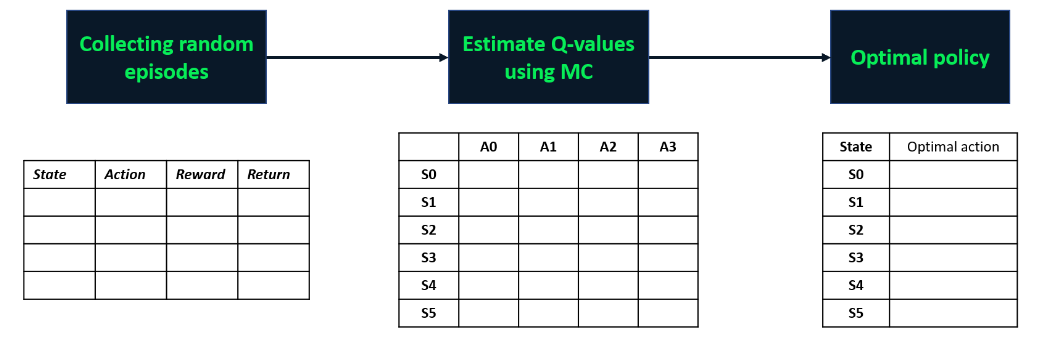

An episode is one complete play of the game from start to termination

Return is the final retun for each episode
eg:

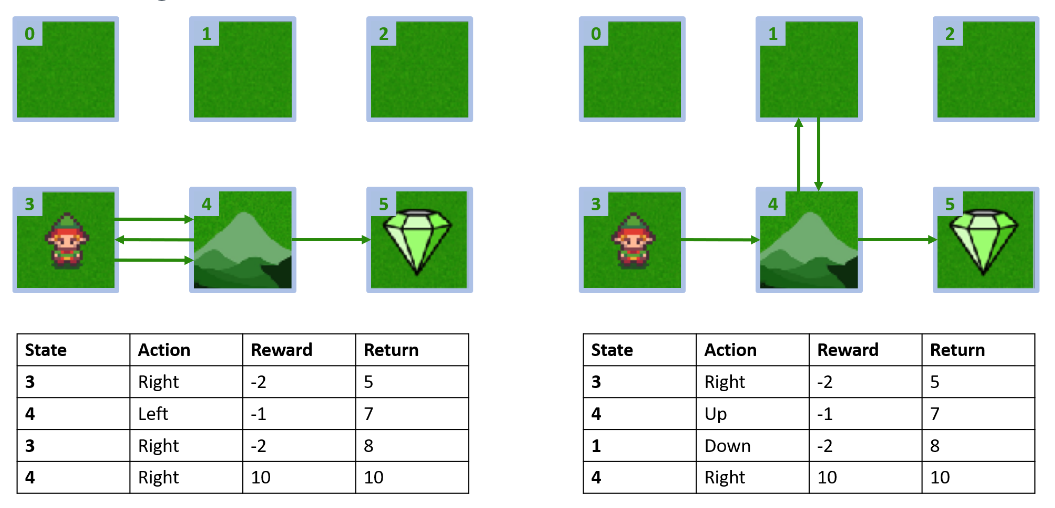

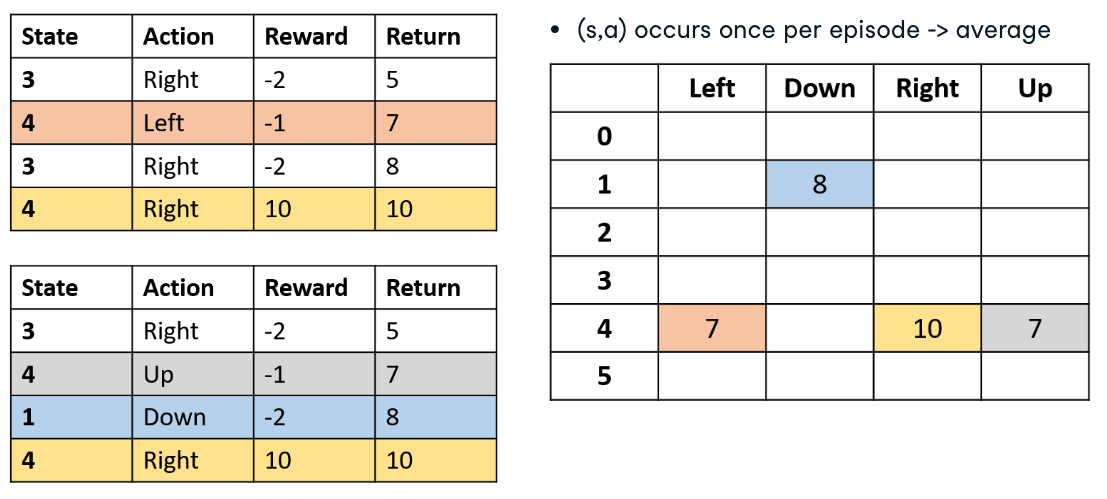

In [12]:
import numpy as np

def generate_episode():

    episode = []

    # Resets environment
    state, info = env.reset()
    terminated = False

    while not terminated:
        
        # Samples an action to start the loop
        action = env.action_space.sample()

        # Generates the following action
        next_state, reward, terminated, truncated, info = env.step(action)

        # Collects the action sequence in an episode list as state, action, reward
        episode.append((state, action, reward))

        # And repeat until terminated
        state = next_state

    return episode

def first_visit_mc(num_episodes):

    # Three np arryas are initialized
    Q = np.zeros((num_states, num_actions)) # For Q values
    returns_sum = np.zeros((num_states, num_actions)) # For cumulative rewards
    returns_count = np.zeros((num_states, num_actions)) # For visit counts

    for i in range(num_episodes):
        episode = generate_episode() # Initialize an episode
        visited_states_actions = set() # This is to keep track of which state action pairs have been visited

        for j, (state, action, reward) in enumerate(episode):

            # This is to make sure only the first episode of (state, action) pair is take to 
            # account (Hence first visit)
            if (state, action) not in visited_states_actions:

                # Here the cumulative rewards and visited counts are stored in the appropriate state, action
                # location of the numpy array grid of returns_sum and returns_count respectively
                returns_sum[state, action] += sum([x[2] for x in episode[j:]])
                returns_count[state, action] += 1

                # This is specific to the first_visit algo
                visited_states_actions.add((state, action))

    nonzero_counts = returns_count != 0 # This is to avoid division by 0

    # This is for getting avg Q for every_visit. For first visit return_count will be 
    # an array of ones, so doesn't make a difference
    Q[nonzero_counts] = returns_sum[nonzero_counts] / returns_count[nonzero_counts] 

    return Q

def every_visit_mc(num_episodes):

    Q = np.zeros((num_states, num_actions))
    returns_sum = np.zeros((num_states, num_actions))
    returns_count = np.zeros((num_states, num_actions))

    for i in range(num_episodes):
        episode = generate_episode()
        
        for j, (state, action, reward) in enumerate(episode):
            
            returns_sum[state, action] += sum([x[2] for x in episode[j:]])
            returns_count[state, action] += 1

    nonzero_counts = returns_count != 0
    Q[nonzero_counts] = returns_sum[nonzero_counts] / returns_count[nonzero_counts]

    return Q

def get_policy():
    # Returns the action corresponding to the max Q
    policy = {state: np.argmax(Q[state]) for state in range(num_states)}
    return policy

## Sample problem

In [6]:
!pip install -r requirements.txt

In [ ]:
'''
Overall whats happening
```````````````````````
Playing different machines 500 times and looking at the reward each time and storing it in the memory array 
in the format of [index of machine played, reward obtained in the play].

How do we get eache of the above?
`````````````````````````````````
Index of the machine played: This can be selected in two ways

1. Random (Exploration): Look at the else statement of the final code block
2. Based on prior exp (Exploitation): The bestArm function spits out the arm that gave the best reward when fed with the 
    memory array. 

Which of these strategies are taken is decided based on epsilon which is the probability of exploration action

'''

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(5)

In [8]:
n = 10
arms = np.random.rand(n)
eps = 0.1 #probability of exploration action

In [9]:
def reward(prob):
    reward = 0
    for i in range(10):
        if random.random() < prob:
            reward += 1
    return reward

In [128]:
#initialize memory array; has 1 row defaulted to random action index
av = np.array([np.random.randint(0,(n+1)), 0]).reshape(1,2) #av = action-value

In [126]:
#greedy method to select best arm based on memory array
def bestArm(a):
    bestArm = 0 #default to 0
    bestMean = 0
    for u in a:
        avg = np.mean(a[np.where(a[:,0] == u[0])][:, 1]) #calculate mean reward for each action
        if bestMean < avg:
            bestMean = avg
            bestArm = u[0]
    return bestArm

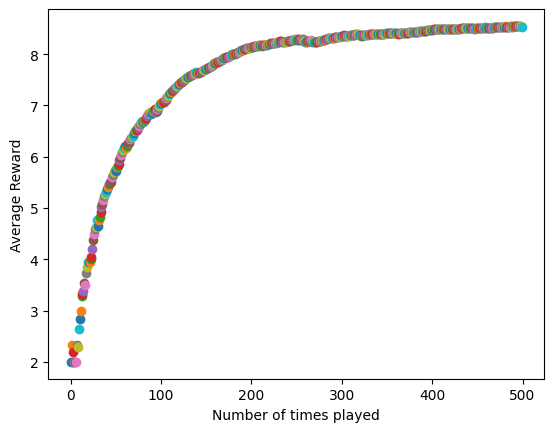

In [130]:
plt.xlabel("Number of times played")
plt.ylabel("Average Reward")
for i in range(500):
    if random.random() > eps: #greedy exploitation action
        choice = bestArm(av)
        thisAV = np.array([[choice, reward(arms[choice])]])
        av = np.concatenate((av, thisAV), axis=0)
    else: #exploration action
        choice = np.where(arms == np.random.choice(arms))[0][0]
        thisAV = np.array([[choice, reward(arms[choice])]]) #choice, reward
        av = np.concatenate((av, thisAV), axis=0) #add to our action-value memory array
    #calculate the mean reward
    runningMean = np.mean(av[:,1])
    plt.scatter(i, runningMean)

In [2]:
import numpy as np
expected_rewards = np.array([1,6,3])
discount_factor = 0.9
discounts = np.array([discount_factor**i for i in range(len(expected_rewards))])
discount_return = np.sum(expected_rewards*discounts)